In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
#Prepare Data
train = pd.read_csv("data_train.csv", parse_dates=['date_time'], index_col='date_time')
test = pd.read_csv("data_test.csv", parse_dates=['date_time'], index_col='date_time')

print(f"\nTrain: {train.index.min()} to {train.index.max()} ({len(train)} hours)")
print(f"Test:  {test.index.min()} to {test.index.max()} ({len(test)} hours)")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train: 2012-03-12 14:00:00 to 2018-09-06 21:00:00 (15248 hours)
Test:  2018-09-06 22:00:00 to 2018-12-09 23:00:00 (720 hours)
Train shape: (15248, 70)
Test shape: (720, 70)


In [3]:
# 2. FEATURE SELECTION FOR LSTM

# Select features for LSTM (multivariate)
feature_cols = [
    'traffic_volume',    # Target (must be first column)
    
    # Weather features
    'temp_c',
    'rain_1h',
    'snow_1h',
    'clouds_all',
    
    # Time features (cyclical encodings preferred for neural networks)
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    
    # Lag features
    'traffic_lag_24',
    'traffic_lag_168',
    
    # Rolling statistics
    'traffic_rolling_mean_24',
    'traffic_rolling_std_24',
    
    # Holiday indicator
    'is_holiday'
]

# Filter to existing columns
feature_cols = [c for c in feature_cols if c in train.columns]

print(f"\nFeatures for LSTM: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Extract feature matrices
train_data = train[feature_cols].values
test_data = test[feature_cols].values

print(f"\nTrain data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Features for LSTM: 14
Features: ['traffic_volume', 'temp_c', 'rain_1h', 'snow_1h', 'clouds_all', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'traffic_lag_24', 'traffic_lag_168', 'traffic_rolling_mean_24', 'traffic_rolling_std_24', 'is_holiday']

Train data shape: (15248, 14)
Test data shape: (720, 14)


In [4]:
# 3.SCALING (FIT ON TRAIN ONLY)-avoid data leakage

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

print(f"Train scaled shape: {train_scaled.shape}")
print(f"Test scaled shape: {test_scaled.shape}")
print(f"Scaled range: [{train_scaled.min():.3f}, {train_scaled.max():.3f}]")

# Save scaler for inverse transform later
import joblib
joblib.dump(scaler, "lstm_scaler.pkl")
print("\nScaler saved to 'lstm_scaler.pkl'")


Train scaled shape: (15248, 14)
Test scaled shape: (720, 14)
Scaled range: [0.000, 1.000]

Scaler saved to 'lstm_scaler.pkl'


In [5]:
# 4. CREATE SEQUENCES FOR LSTM
def create_sequences(data, window_size=24):
    """
    Create sequences for LSTM input.
    
    Args:
        data: scaled data array
        window_size: lookback period (hours)
    
    Returns:
        X: sequences of shape (samples, window_size, features)
        y: targets of shape (samples,)
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])  # All features
        y.append(data[i, 0])                 # Target (traffic_volume is col 0)
    return np.array(X), np.array(y)

# Define window size (24 hours = 1 day of history)
WINDOW_SIZE = 24

# Create sequences
X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

# print(f"\nWindow size: {WINDOW_SIZE} hours")
# print(f"X_train shape: {X_train.shape}  (samples, timesteps, features)")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test shape:  {X_test.shape}")
# print(f"y_test shape:  {y_test.shape}")

n_features = X_train.shape[2]
print(f"\nNumber of features: {n_features}")


Number of features: 14


In [6]:
# 5. BUILD LSTM MODEL
model = Sequential([
    # First LSTM layer (returns sequences for next LSTM)
    LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, n_features)),
    Dropout(0.3),
    
    # Second LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    
    # Dense layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\nModel Architecture:")
model.summary()



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,737 (487.25 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#  6. TRAIN MODEL

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train model
print("\nTraining in progress...")
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



Training in progress...
Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - loss: 0.0375 - mae: 0.1474 - val_loss: 0.0148 - val_mae: 0.0868 - learning_rate: 0.0010
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - loss: 0.0193 - mae: 0.1032 - val_loss: 0.0063 - val_mae: 0.0601 - learning_rate: 0.0010
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - loss: 0.0131 - mae: 0.0842 - val_loss: 0.0043 - val_mae: 0.0501 - learning_rate: 0.0010
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 0.0108 - mae: 0.0762 - val_loss: 0.0037 - val_mae: 0.0430 - learning_rate: 0.0010
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - loss: 0.0092 - mae: 0.0706 - val_loss: 0.0032 - val_mae: 0.0411 - learning_rate: 0.0010
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 0.0086 - mae: 0.0676 - val_loss: 0.0025 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0080 - mae: 0.0652 - val_loss: 0.0024 - val_mae

In [8]:
# 7. MAKE PREDICTIONS

# Predict on scaled data
y_train_pred_scaled = model.predict(X_train, verbose=0).flatten()
y_test_pred_scaled = model.predict(X_test, verbose=0).flatten()

# Inverse transform predictions
# Create dummy arrays for inverse transform (scaler expects all features)
def inverse_transform_target(scaler, scaled_values, feature_cols):
    """Inverse transform only the target variable"""
    n_features = len(feature_cols)
    dummy = np.zeros((len(scaled_values), n_features))
    dummy[:, 0] = scaled_values  # traffic_volume is first column
    
    inverse = scaler.inverse_transform(dummy)
    return inverse[:, 0]

# Inverse transform
y_train_inv = inverse_transform_target(scaler, y_train, feature_cols)
y_test_inv = inverse_transform_target(scaler, y_test, feature_cols)
y_train_pred_inv = inverse_transform_target(scaler, y_train_pred_scaled, feature_cols)
y_test_pred_inv = inverse_transform_target(scaler, y_test_pred_scaled, feature_cols)

print(f"\nPredictions shape:")
print(f"  Train: {y_train_pred_inv.shape}")
print(f"  Test:  {y_test_pred_inv.shape}")



Predictions shape:
  Train: (15224,)
  Test:  (696,)


In [ ]:
# 8. EVALUATE MODEL
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
train_r2 = r2_score(y_train_inv, y_train_pred_inv)
test_r2 = r2_score(y_test_inv, y_test_pred_inv)

print(f"\nLSTM Model Performance:")
print(f"Train → RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
print(f"Test  → RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")

# Check for overfitting
overfitting_gap = train_r2 - test_r2
print(f"\nOverfitting check: Train R² - Test R² = {overfitting_gap:.4f}")
if overfitting_gap > 0.10:
    print("Warning: Significant overfitting detected")
elif overfitting_gap > 0.05:
    print(" Mild overfitting detected")
else:
    print("Model generalizes well")



LSTM Model Performance:
Train → RMSE: 382.78, MAE: 244.30, R²: 0.9625
Test  → RMSE: 280.02, MAE: 208.08, R²: 0.9802

Overfitting check: Train R² - Test R² = -0.0176
Model generalizes well


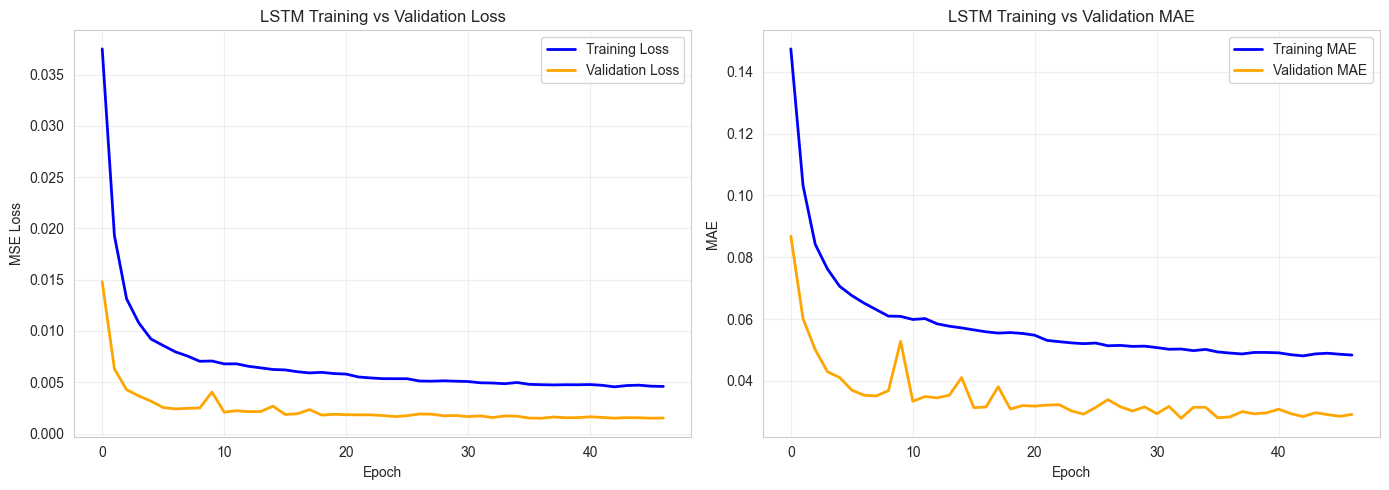

In [10]:
# 9. TRAINING HISTORY VISUALIZATION

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('LSTM Training vs Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE curve
axes[1].plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('LSTM Training vs Validation MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

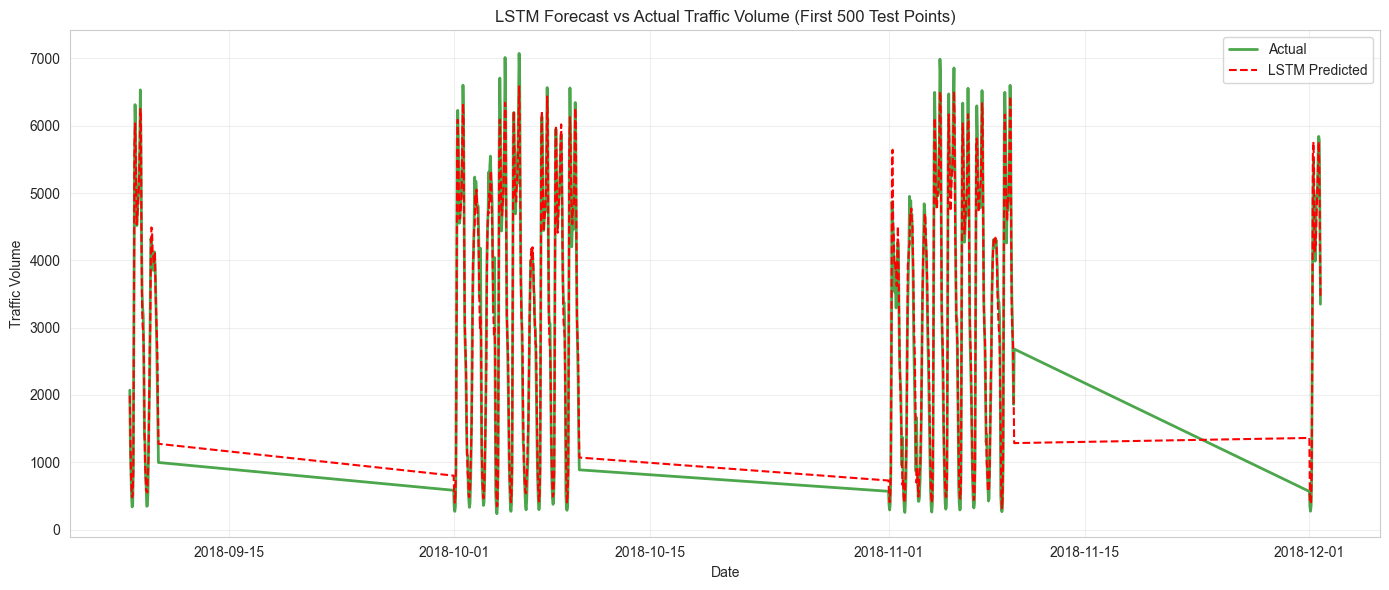

In [11]:
#  10. PREDICTIONS VISUALIZATION

# Get corresponding dates for test predictions
# Account for window_size offset
test_dates = test.index[WINDOW_SIZE:]

# Plot first 500 test points
plot_points = min(500, len(y_test_inv))

plt.figure(figsize=(14, 6))
plt.plot(test_dates[:plot_points], y_test_inv[:plot_points], 
         label='Actual', color='green', linewidth=2, alpha=0.7)
plt.plot(test_dates[:plot_points], y_test_pred_inv[:plot_points], 
         label='LSTM Predicted', color='red', linestyle='--', linewidth=1.5)
plt.title(f'LSTM Forecast vs Actual Traffic Volume (First {plot_points} Test Points)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


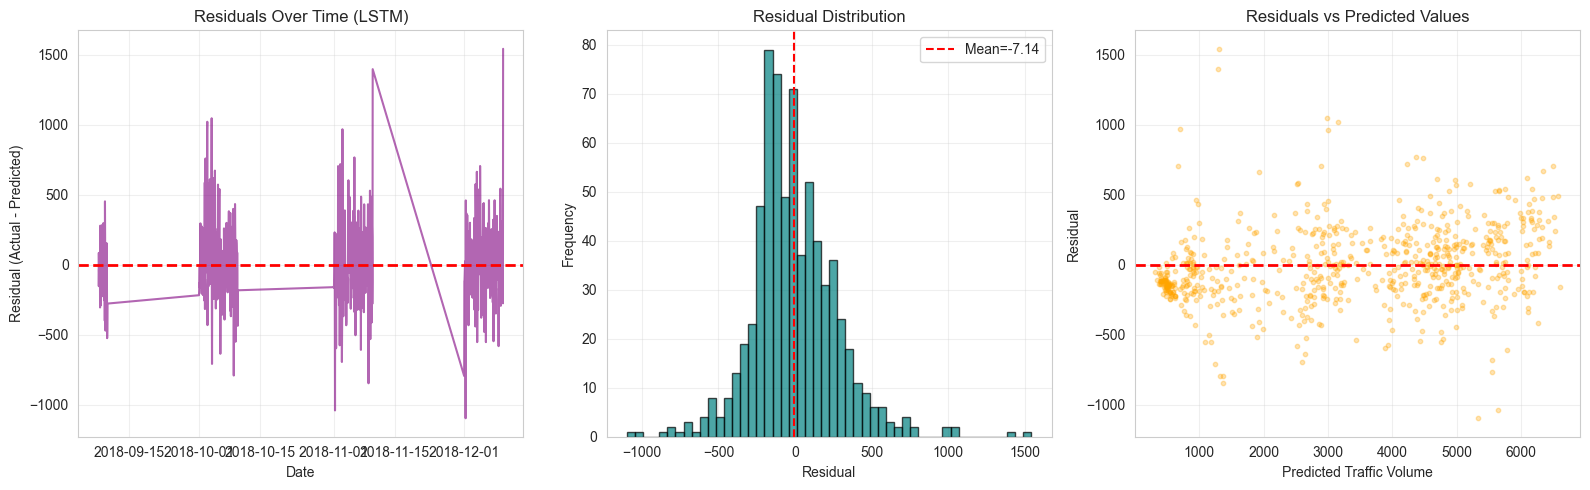


Residual Statistics:
count     696.000000
mean       -7.138904
std       280.128169
min     -1096.953736
25%      -169.669656
50%       -32.742591
75%       149.657416
max      1543.198820
dtype: float64


In [12]:
# 11. RESIDUAL ANALYSIS

residuals = y_test_inv - y_test_pred_inv

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Residuals over time
axes[0].plot(test_dates, residuals, color='purple', alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time (LSTM)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].grid(alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', 
                label=f'Mean={residuals.mean():.2f}')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Residuals vs Predicted
axes[2].scatter(y_test_pred_inv, residuals, alpha=0.3, color='orange', s=10)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Residuals vs Predicted Values')
axes[2].set_xlabel('Predicted Traffic Volume')
axes[2].set_ylabel('Residual')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("\nResidual Statistics:")
print(pd.Series(residuals).describe())


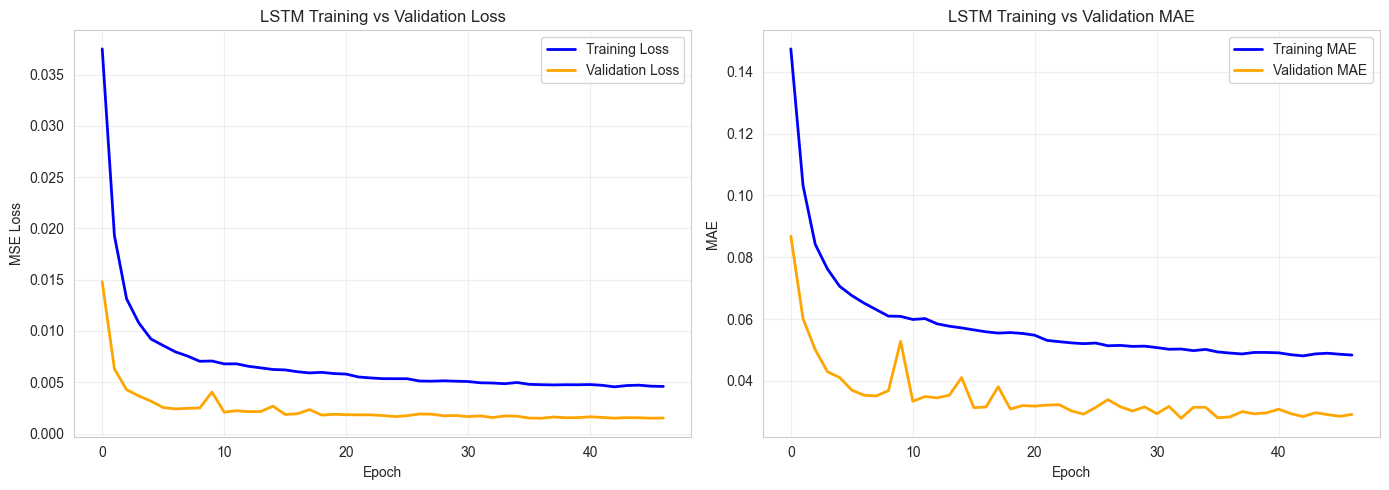

In [15]:
# 10. TRAINING HISTORY VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('LSTM Training vs Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE curve
axes[1].plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('LSTM Training vs Validation MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 12. NAIVE BASELINE COMPARISON

# Naive seasonal: use lag 168 
if 'traffic_lag_168' in test.columns:
    # Get naive predictions (accounting for window offset)
    naive_pred = test['traffic_lag_168'].values[WINDOW_SIZE:]
    
    # Remove any NaNs
    valid_idx = ~np.isnan(naive_pred)
    naive_pred_clean = naive_pred[valid_idx]
    y_test_clean = y_test_inv[valid_idx]
    
    naive_rmse = np.sqrt(mean_squared_error(y_test_clean, naive_pred_clean))
    naive_mae = mean_absolute_error(y_test_clean, naive_pred_clean)
    naive_r2 = r2_score(y_test_clean, naive_pred_clean)
    
    print(f"\nNaive Seasonal Baseline (lag 168h):")
    print(f"  RMSE: {naive_rmse:.2f}")
    print(f"  MAE:  {naive_mae:.2f}")
    print(f"  R²:   {naive_r2:.4f}")
    
    print(f"\nLSTM Improvement over Naive:")
    print(f"  RMSE reduction: {((naive_rmse - test_rmse) / naive_rmse * 100):.1f}%")
    print(f"  MAE reduction: {((naive_mae - test_mae) / naive_mae * 100):.1f}%")
else:
    print("\nWarning: traffic_lag_168 not available for naive baseline")



Naive Seasonal Baseline (lag 168h):
  RMSE: 1493.87
  MAE:  982.14
  R²:   0.4359

LSTM Improvement over Naive:
  RMSE reduction: 81.3%
  MAE reduction: 78.8%


In [14]:
#13. SAVE MODEL

model.save('lstm_traffic_model.h5')
print("\nModel saved to 'lstm_traffic_model.h5'")

# Save metrics for comparison
lstm_results = {
    'model': 'LSTM',
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'train_mae': train_mae,
    'test_mae': test_mae,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'window_size': WINDOW_SIZE,
    'n_features': n_features
}

import pandas as pd

df = pd.DataFrame([lstm_results])   # wrap in list so it's one row

# Save to CSV
df.to_csv("lstm_results.csv", index=False)

print("Results saved to 'lstm_results.csv'")



Model saved to 'lstm_traffic_model.h5'
Results saved to 'lstm_results.csv'


**Observations:**

- Both training and validation loss decrease smoothly